In [ ]:
from utils import print_score


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_auc_score, f1_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [ ]:
ruta = "./data/dataset_balanceado.csv"
X_train, X_val, X_test, y_train, y_val, y_test = cargar_y_preprocesar_datos(ruta)

##### Modelo Base (Sin manejo de desbalanceo) 

Este modelo sirve como punto de referencia para medir las mejoras.

In [10]:
modelo_base = LogisticRegression(solver='liblinear', random_state=42)
modelo_base.fit(X_train, y_train)

print_score(modelo_base, X_train, y_train, X_val, y_val, train=True)
print_score(modelo_base, X_train, y_train, X_val, y_val, train=False)

Train Result:
Accuracy Score: 99.00%
_______________________________________________
CLASSIFICATION REPORT:
                      0      1  accuracy     macro avg  weighted avg
precision      0.990000    0.0      0.99      0.495000      0.980100
recall         1.000000    0.0      0.99      0.500000      0.990000
f1-score       0.994975    0.0      0.99      0.497487      0.985025
support    59400.000000  600.0      0.99  60000.000000  60000.000000
_______________________________________________
Confusion Matrix: 
 [[59400     0]
 [  600     0]]

Test Result:
Accuracy Score: 99.00%
_______________________________________________
CLASSIFICATION REPORT:
                      0      1  accuracy     macro avg  weighted avg
precision      0.990000    0.0      0.99      0.495000      0.980100
recall         1.000000    0.0      0.99      0.500000      0.990000
f1-score       0.994975    0.0      0.99      0.497487      0.985025
support    19800.000000  200.0      0.99  20000.000000  20000.00

##### Ponderación de Clases

Se utiliza **class_weight='balanced'** para penalizar más los errores en la clase minoritaria.

In [11]:
modelo_balanceado = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42)
modelo_balanceado.fit(X_train, y_train)

print_score(modelo_balanceado, X_train, y_train, X_val, y_val, train=True)
print_score(modelo_balanceado, X_train, y_train, X_val, y_val, train=False)

Train Result:
Accuracy Score: 51.26%
_______________________________________________
CLASSIFICATION REPORT:
                      0           1  accuracy     macro avg  weighted avg
precision      0.991397    0.011462  0.512633      0.501429      0.981597
recall         0.512155    0.560000  0.512633      0.536077      0.512633
f1-score       0.675399    0.022464  0.512633      0.348932      0.668870
support    59400.000000  600.000000  0.512633  60000.000000  60000.000000
_______________________________________________
Confusion Matrix: 
 [[30422 28978]
 [  264   336]]

Test Result:
Accuracy Score: 50.66%
_______________________________________________
CLASSIFICATION REPORT:
                      0           1  accuracy     macro avg  weighted avg
precision      0.991003    0.011026    0.5066      0.501014      0.981203
recall         0.506212    0.545000    0.5066      0.525606      0.506600
f1-score       0.670121    0.021614    0.5066      0.345868      0.663636
support    19800.00

##### SMOTE y Submuestreo 

Para un mejor control, crear un pipeline que primero aplica **SMOTE** para generar muestras sintéticas de la clase minoritaria, y luego aplica **submuestreo aleatorio** para reducir la clase mayoritaria.

Usar un pipeline de `imblearn` es crucial para evitar el "data leakage", ya que el remuestreo se ajusta solo a los datos de entrenamiento durante el `fit`.

In [15]:
pipeline_resampling = Pipeline([
    ('oversample', SMOTE(sampling_strategy=0.2, random_state=42)),
    ('undersample', RandomUnderSampler(sampling_strategy=0.5, random_state=42)),
    ('model', LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced'))
])

c = pipeline_resampling.fit(X_train, y_train)

print_score(c, X_train, y_train, X_val, y_val, train=True)
print_score(c, X_train, y_train, X_val, y_val, train=False)

Train Result:
Accuracy Score: 98.29%
_______________________________________________
CLASSIFICATION REPORT:
                      0           1  accuracy     macro avg  weighted avg
precision      0.990060    0.018100    0.9829      0.504080      0.980341
recall         0.992694    0.013333    0.9829      0.503013      0.982900
f1-score       0.991375    0.015355    0.9829      0.503365      0.981615
support    59400.000000  600.000000    0.9829  60000.000000  60000.000000
_______________________________________________
Confusion Matrix: 
 [[58966   434]
 [  592     8]]

Test Result:
Accuracy Score: 98.16%
_______________________________________________
CLASSIFICATION REPORT:
                      0           1  accuracy     macro avg  weighted avg
precision      0.989965    0.005882    0.9816      0.497924      0.980124
recall         0.991465    0.005000    0.9816      0.498232      0.981600
f1-score       0.990714    0.005405    0.9816      0.498060      0.980861
support    19800.00

##### Ajuste del Umbral de Decisión (maximiza f1-score)

Ahora que tenemos un modelo más robusto, podemos ajustar el umbral de probabilidad para optimizar el balance entre precisión y recall, buscando maximizar el F1-score.


Mejor umbral encontrado: 0.3381
F1-Score máximo en validación: 0.0238


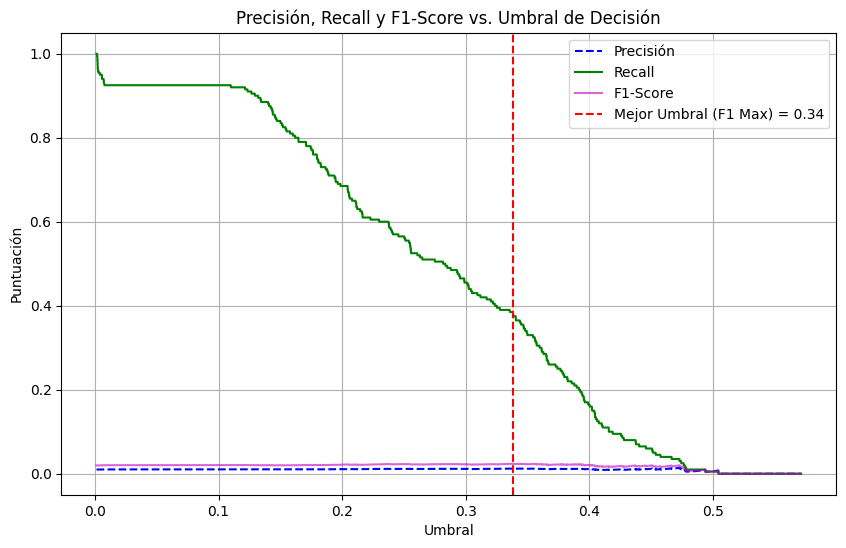

In [16]:
y_scores = pipeline_resampling.predict_proba(X_val)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_val, y_scores)

epsilon = 1e-7
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + epsilon)

# Encontrar el mejor umbral que maximiza el F1-score
best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]

print(f"Mejor umbral encontrado: {best_threshold:.4f}")
print(f"F1-Score máximo en validación: {f1_scores[best_threshold_idx]:.4f}")

# Visualización de la curva de Precisión-Recall vs Umbral
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precisión")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.plot(thresholds, f1_scores[:-1], "m-", label="F1-Score", alpha=0.6)
plt.axvline(best_threshold, color='r', linestyle='--', label=f'Mejor Umbral (F1 Max) = {best_threshold:.2f}')
plt.title("Precisión, Recall y F1-Score vs. Umbral de Decisión")
plt.xlabel("Umbral")
plt.ylabel("Puntuación")
plt.grid(True)
plt.legend()
plt.show()

dar rango de 0 a 1, mejorar la escala del eje y

##### Resumen:

El smote con remuestreo no estaba funcionando bien, no clasifica ningun fraude ni en entrenamiento ni en validacion, los clasifica todos como no fraude.

Al ajustar los pesos con `class_weight=balanced` mejoró minimamnete (comenzo a detectar fraude)

In [20]:
print("Evaluación Final del Pipeline en Validación con Umbral Optimizado")
y_pred_final = (y_scores >= best_threshold).astype(int)

print("Matriz de Confusión Final:")
print(confusion_matrix(y_val, y_pred_final))
print("\nReporte de Clasificación Final:")
print(classification_report(y_val, y_pred_final))

roc_auc = roc_auc_score(y_val, y_scores)
print(f"ROC AUC Score: {roc_auc:.4f}")

Evaluación Final del Pipeline en Validación con Umbral Optimizado
Matriz de Confusión Final:
[[13609  6191]
 [  123    77]]

Reporte de Clasificación Final:
              precision    recall  f1-score   support

           0       0.99      0.69      0.81     19800
           1       0.01      0.39      0.02       200

    accuracy                           0.68     20000
   macro avg       0.50      0.54      0.42     20000
weighted avg       0.98      0.68      0.80     20000

ROC AUC Score: 0.5354


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, recall_score

from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression

pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('sampler', SMOTE(random_state=42)),
    ('undersampler', RandomUnderSampler(random_state=42)),
    ('model', LogisticRegression(solver='liblinear', random_state=42, max_iter=1000)) 
])

param_grid = {
    'model__C': [0.01, 0.1, 1],
    'model__penalty': ['l1', 'l2'],
    'model__class_weight': ['balanced', None], # Probar si balanced es siempre mejor
    'sampler__sampling_strategy': [0.1, 0.2], # Reduje el rango para ser más rápido
    'undersampler__sampling_strategy': [0.5, 0.6] # Reduje el rango
}

scorer = make_scorer(f1_score, pos_label=1) 

grid_search = GridSearchCV(pipeline_lr, param_grid, cv=3, scoring=scorer, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train) 

print(f"Mejor score (F1) de validación cruzada: {grid_search.best_score_:.4f}")
print(f"Mejores parámetros: {grid_search.best_params_}")

best_logistic_model = grid_search.best_estimator_

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Mejor score (F1) de validación cruzada: 0.0203
Mejores parámetros: {'model__C': 0.01, 'model__class_weight': 'balanced', 'model__penalty': 'l2', 'sampler__sampling_strategy': 0.1, 'undersampler__sampling_strategy': 0.6}


In [22]:
print_score(grid_search, X_train, y_train, X_val, y_val, train=False)

Test Result:
Accuracy Score: 50.00%
_______________________________________________
CLASSIFICATION REPORT:
                      0           1  accuracy     macro avg  weighted avg
precision      0.990098    0.010098       0.5      0.500098      0.980298
recall         0.499949    0.505000       0.5      0.502475      0.500000
f1-score       0.664407    0.019800       0.5      0.342104      0.657961
support    19800.000000  200.000000       0.5  20000.000000  20000.000000
_______________________________________________
Confusion Matrix: 
 [[9899 9901]
 [  99  101]]



#### Conclusión: 
Se ha explorado el modelo de Regresión Logística, incluyendo estrategias de balanceo de clases como `class_weight='balanced'` y `remuestreo (SMOTE y RandomUnderSampler)`. A pesar de estas técnicas y la optimización del umbral de decisión para el F1-score, la Regresión Logística muestra una capacidad limitada para detectar fraudes (recall del 39%) con una alta cantidda de falsos positivos (precisión del 1%). El bajo valor de ROC AUC (0.5354) sugiere que con los features actuales el modelo no está aprendiendo patrones lo suficientemente generales para poder distinguir entre transacciones fraudulentas y legítimas, basicamente las características actuales no son linealmente separables para este modelo por lo cual no es adecuado para este problema.  